In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report

In [96]:
df = pd.read_csv('student_admission_record_dirty.csv')

In [97]:
df = df.dropna(subset=['Admission Status'])
df = df.dropna(subset=['Name'])

In [98]:
df.loc[df['High School Percentage'] < 0, 'High School Percentage'] = np.nan
df.loc[df['Age'] < 0, 'Age'] = np.nan
df.loc[df['Admission Test Score'] < 0, 'Admission Test Score'] = np.nan

In [99]:
median_imputer = SimpleImputer(strategy="median")
df['Age'] = median_imputer.fit_transform(df[['Age']])
df['Admission Test Score'] = median_imputer.fit_transform(df[['Admission Test Score']])
df['High School Percentage'] = median_imputer.fit_transform(df[['High School Percentage']])


In [100]:
label_encoder = LabelEncoder()
df['Gender'] = label_encoder.fit_transform(df['Gender'])
df['City'] = label_encoder.fit_transform(df['City'])

In [101]:
target_encoder = LabelEncoder()
df['Target'] = target_encoder.fit_transform(df['Admission Status'])

In [102]:
X = df[['Age', 'Gender', 'Admission Test Score', 'High School Percentage', 'City']].values
y = df['Target'].values

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [104]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [105]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

class StudentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = StudentDataset(X_train, y_train)
test_ds = StudentDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

In [106]:
class SimpleNet(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        return self.net(x).squeeze(1)

class DeepNet(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )

    def forward(self, x):
        return self.net(x).squeeze(1)

class DropoutNet(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1),
        )

    def forward(self, x):
        return self.net(x).squeeze(1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

input_size = X_train.shape[1]
model1 = SimpleNet(input_size).to(device)
model2 = DeepNet(input_size).to(device)
model3 = DropoutNet(input_size).to(device)

print(model1)

Using device: cpu
SimpleNet(
  (net): Sequential(
    (0): Linear(in_features=5, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [114]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

def train_model(model, train_loader, test_loader, num_epochs=200, lr=0.001):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    test_losses = []
    test_accuracies = []

    for epoch in tqdm(range(num_epochs)):
        model.train()
        train_loss = 0.0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * X_batch.size(0)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        model.eval()
        test_loss = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                test_loss += loss.item() * X_batch.size(0)

                preds = (torch.sigmoid(outputs) > 0.5).float()
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(y_batch.cpu().numpy())

        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)

        test_acc = accuracy_score(all_labels, all_preds)
        test_accuracies.append(test_acc)

        if (epoch + 1) % 20 == 0:
            print(f"\nEpoch {epoch+1}/{num_epochs}")
            print(f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

    return train_losses, test_losses, test_accuracies

In [115]:
history1 = train_model(model1, train_loader, test_loader, num_epochs=100)


 34%|███▍      | 34/100 [00:00<00:01, 62.95it/s]


Epoch 20/100
Train Loss: 0.6292, Test Loss: 0.7636, Test Acc: 0.3214


 51%|█████     | 51/100 [00:00<00:00, 73.17it/s]


Epoch 40/100
Train Loss: 0.6200, Test Loss: 0.7670, Test Acc: 0.3214


 68%|██████▊   | 68/100 [00:01<00:00, 63.59it/s]


Epoch 60/100
Train Loss: 0.6111, Test Loss: 0.7795, Test Acc: 0.2857


 90%|█████████ | 90/100 [00:01<00:00, 56.08it/s]


Epoch 80/100
Train Loss: 0.6022, Test Loss: 0.7679, Test Acc: 0.2857


100%|██████████| 100/100 [00:01<00:00, 60.32it/s]


Epoch 100/100
Train Loss: 0.5937, Test Loss: 0.7862, Test Acc: 0.2857


In [116]:
history2 = train_model(model2, train_loader, test_loader, num_epochs=100)


 31%|███       | 31/100 [00:00<00:01, 57.18it/s]


Epoch 20/100
Train Loss: 0.0291, Test Loss: 1.6591, Test Acc: 0.5000


 55%|█████▌    | 55/100 [00:00<00:00, 69.11it/s]


Epoch 40/100
Train Loss: 0.0142, Test Loss: 1.9530, Test Acc: 0.5714


 70%|███████   | 70/100 [00:01<00:00, 71.54it/s]


Epoch 60/100
Train Loss: 0.0070, Test Loss: 2.1764, Test Acc: 0.5357


 86%|████████▌ | 86/100 [00:01<00:00, 58.23it/s]


Epoch 80/100
Train Loss: 0.0040, Test Loss: 2.3793, Test Acc: 0.5714


100%|██████████| 100/100 [00:01<00:00, 63.56it/s]


Epoch 100/100
Train Loss: 0.0026, Test Loss: 2.5288, Test Acc: 0.5357


In [117]:
history3 = train_model(model3, train_loader, test_loader, num_epochs=100)


 28%|██▊       | 28/100 [00:00<00:01, 50.68it/s]


Epoch 20/100
Train Loss: 0.5019, Test Loss: 0.8440, Test Acc: 0.5357


 45%|████▌     | 45/100 [00:00<00:01, 46.60it/s]


Epoch 40/100
Train Loss: 0.4798, Test Loss: 0.8555, Test Acc: 0.5000


 81%|████████  | 81/100 [00:01<00:00, 80.38it/s]


Epoch 60/100
Train Loss: 0.4953, Test Loss: 0.9414, Test Acc: 0.5000

Epoch 80/100
Train Loss: 0.3922, Test Loss: 0.9131, Test Acc: 0.5000


100%|██████████| 100/100 [00:01<00:00, 63.17it/s]


Epoch 100/100
Train Loss: 0.3758, Test Loss: 0.9144, Test Acc: 0.6071


In [118]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            preds = (torch.sigmoid(outputs) > 0.5).float()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=['Rejected', 'Accepted']))

    return accuracy


acc1 = evaluate_model(model1, test_loader)

acc2 = evaluate_model(model2, test_loader)

acc3 = evaluate_model(model3, test_loader)

Accuracy: 0.2857

Classification Report:
              precision    recall  f1-score   support

    Rejected       0.21      0.44      0.29         9
    Accepted       0.44      0.21      0.29        19

    accuracy                           0.29        28
   macro avg       0.33      0.33      0.29        28
weighted avg       0.37      0.29      0.29        28

Accuracy: 0.5357

Classification Report:
              precision    recall  f1-score   support

    Rejected       0.36      0.56      0.43         9
    Accepted       0.71      0.53      0.61        19

    accuracy                           0.54        28
   macro avg       0.54      0.54      0.52        28
weighted avg       0.60      0.54      0.55        28

Accuracy: 0.6071

Classification Report:
              precision    recall  f1-score   support

    Rejected       0.43      0.67      0.52         9
    Accepted       0.79      0.58      0.67        19

    accuracy                           0.61        28
   ma

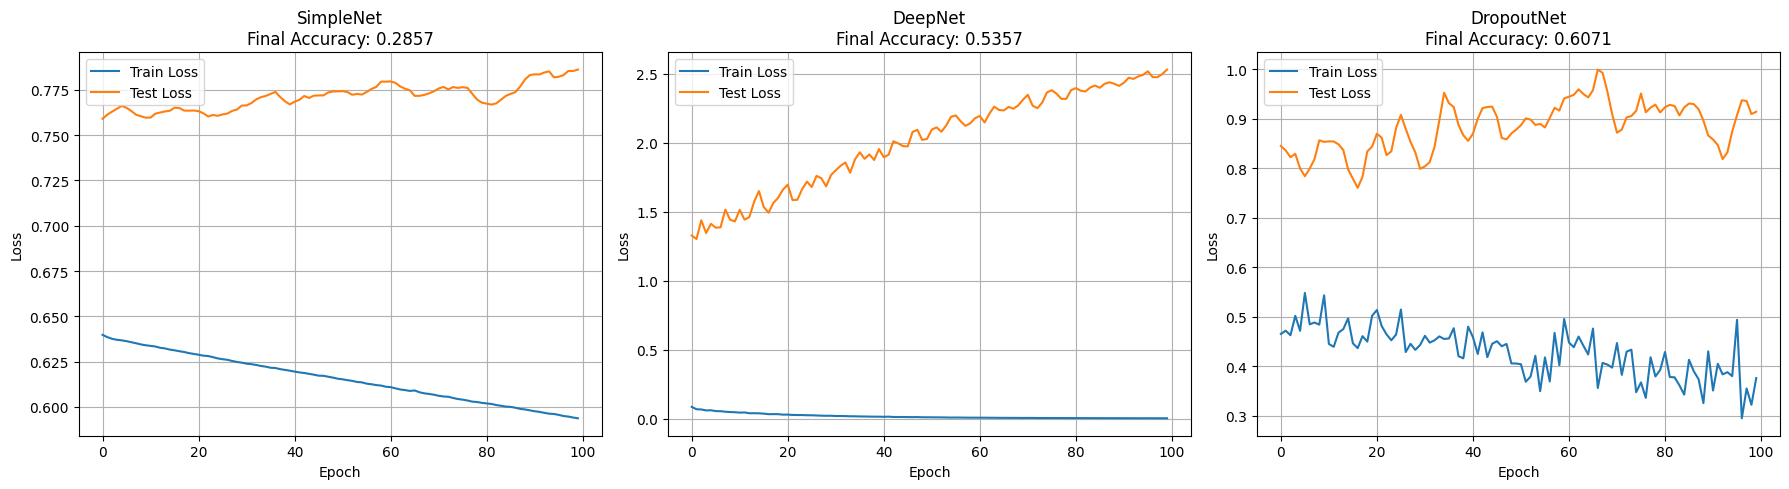

In [121]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models_info = [
    ('SimpleNet', history1, acc1),
    ('DeepNet', history2, acc2),
    ('DropoutNet', history3, acc3)
]

for i, (name, (train_loss, test_loss, test_acc), acc) in enumerate(models_info):
    axes[i].plot(train_loss, label='Train Loss')
    axes[i].plot(test_loss, label='Test Loss')
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Loss')
    axes[i].set_title(f'{name}\nFinal Accuracy: {acc:.4f}')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()